In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from nltk.corpus import stopwords
import json
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbEvalCallback, WandbModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

In [44]:
Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.utils.pad_sequences
Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense
Embedding = tf.keras.layers.Embedding
LSTM = tf.keras.layers.LSTM
SpatialDropout1D = tf.keras.layers.SpatialDropout1D
EarlyStopping = tf.keras.callbacks.EarlyStopping
to_categorical = tf.keras.utils.to_categorical
Dropout = tf.keras.layers.Dropout

In [60]:
config_data = json.load(open('../config.json'))
HF_TOKEN = config_data['HF_TOKEN']
WANDB_TOKEN = config_data['WANDB_TOKEN']

wandb.login(key=WANDB_TOKEN)

run = wandb.init(
    project='wz_lstm_classifier',
    config={"model_name": "LSTM"}
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kawis\_netrc


In [46]:
id_to_label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
label_to_id_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
cefr_levels = ["A1", "A2", "B1", "B2", "C1", "C2"]

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [47]:
config = wandb.config

config.maxlen = 320
config.vocab_size = 20000
config.embedding_dims = 100
config.epochs = 7
config.hidden_dims = 100
config.batch_size = 32

In [48]:
train = pd.read_csv('../datasets/archived/em_train.csv')
test = pd.read_csv('../datasets/archived/em_test.csv')
validation = pd.read_csv('../datasets/archived/em_val.csv')

train['level'] = train['label'].apply(lambda x: id_to_label_mapping[x])
test['level'] = test['label'].apply(lambda x: id_to_label_mapping[x])
validation['level'] = validation['label'].apply(lambda x: id_to_label_mapping[x])

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
validation = validation.sample(frac=1).reset_index(drop=True)

test = pd.concat([test,validation], ignore_index=True)
test = pd.concat([test,validation], ignore_index=True)

In [49]:
def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)  
    text = text.replace('x', '')
    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [50]:
train['cleaned_text'] = train['text'].apply(clean_text)
test['cleaned_text'] = test['text'].apply(clean_text)
validation['cleaned_text'] = validation['text'].apply(clean_text)

train['cleaned_text'] = train['cleaned_text'].str.replace('\d+', '')
test['cleaned_text'] = test['cleaned_text'].str.replace('\d+', '')
validation['cleaned_text'] = validation['cleaned_text'].str.replace('\d+', '')

In [51]:
tokenizer = Tokenizer(num_words=config.vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts( pd.concat([train['cleaned_text'], test['cleaned_text'], validation['cleaned_text']], ignore_index=True).values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16908 unique tokens.


In [52]:
X_train_raw = train['cleaned_text']
Y_train_raw = train['label']
X_test_raw = test['cleaned_text']
Y_test_raw = test['label']

X_train = tokenizer.texts_to_sequences(X_train_raw.values)
X_train = pad_sequences(X_train, maxlen=config.maxlen)

Y_train = pd.get_dummies(Y_train_raw).values


X_test = tokenizer.texts_to_sequences(X_test_raw.values)
X_test = pad_sequences(X_test, maxlen=config.maxlen)

Y_test = pd.get_dummies(Y_test_raw).values

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(16000, 320) (16000, 6)
(6000, 320) (6000, 6)


In [53]:
model = Sequential()
model.add(Embedding(config.vocab_size, config.embedding_dims))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(config.hidden_dims, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [54]:
class WandbClfEvalCallback(WandbEvalCallback):
    def __init__(self, validation_data, data_table_columns, pred_table_columns):
        super().__init__(data_table_columns, pred_table_columns)

        self.x = validation_data[0]
        self.y = validation_data[1]

    def add_ground_truth(self, logs=None):
        for idx, (text, label) in enumerate(zip(self.x, self.y)):
            self.data_table.add_data(idx, text, label)

    def add_model_predictions(self, epoch, logs=None):
        preds = self.model.predict(self.x, verbose=0)
        preds = tf.argmax(preds, axis=-1)

        data_table_ref = self.data_table_ref
        table_idxs = data_table_ref.get_index()

        for idx in table_idxs:
            pred = preds[idx]
            self.pred_table.add_data(
                epoch,
                data_table_ref.data[idx][0],
                data_table_ref.data[idx][1],
                data_table_ref.data[idx][2],
                pred,
            )

history = model.fit(
    X_train,Y_train,
    epochs=config.epochs,
    batch_size=config.batch_size,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), WandbMetricsLogger(),
               WandbClfEvalCallback(
                   validation_data=(X_train, Y_train),
                   data_table_columns=["idx", "text", "label"],
                   pred_table_columns=["epoch", "idx", "text", "label", "pred"],
               )]
)

wandb:   1 of 1 files downloaded.  


Epoch 1/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 48s 118ms/step - accuracy: 0.4070 - loss: 1.4938 - val_accuracy: 0.7837 - val_loss: 0.6399
Epoch 2/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 47s 118ms/step - accuracy: 0.8748 - loss: 0.4071 - val_accuracy: 0.9097 - val_loss: 0.2574
Epoch 3/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 48s 120ms/step - accuracy: 0.9536 - loss: 0.1393 - val_accuracy: 0.9159 - val_loss: 0.2475
Epoch 4/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 48s 121ms/step - accuracy: 0.9724 - loss: 0.0807 - val_accuracy: 0.9103 - val_loss: 0.2578
Epoch 5/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 51s 127ms/step - accuracy: 0.9837 - loss: 0.0503 - val_accuracy: 0.8956 - val_loss: 0.3561
Epoch 6/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 49s 122ms/step - accuracy: 0.9865 - loss: 0.0418 - val_accuracy: 0.9059 - val_loss: 0.2986


In [55]:
accuracy = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9193 - loss: 0.2593
Test set
  Loss: 0.264
  Accuracy: 0.918


In [63]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
wandb.log({"Loss": plt})

C:\Users\kawis\anaconda3\Lib\site-packages\plotly\matplotlylib\renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [61]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
wandb.log({"Accuracy": plt})

C:\Users\kawis\anaconda3\Lib\site-packages\plotly\matplotlylib\renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [64]:
import datetime 

def make_predictions(p_model, p_test):
    print(f'Started prediction at {datetime.datetime.now()}')
    for index, row in p_test.iterrows():
        sentence = row['cleaned_text']
        pred_sentence = tokenizer.texts_to_sequences([sentence])
        pred_sentence = pad_sequences(pred_sentence, maxlen=config.maxlen)
        pred = model.predict(pred_sentence)
        p_test.loc[index, 'predictions'] = cefr_levels[np.argmax(pred)]


make_predictions(model, test)
print(f'Ended prediction at {datetime.datetime.now()}')

Started prediction at 2024-08-14 23:45:19.967122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Accuracy: 0.918
Accuracy for label A1: 0.973
Accuracy for label A2: 0.914
Accuracy for label B1: 0.843
Accuracy for label B2: 0.943
Accuracy for label C1: 0.836
Accuracy for label C2: 0.855

Classification Report:
              precision    recall  f1-score   support

          A1       0.92      0.97      0.95      1681
          A2       0.95      0.91      0.93      2103
          B1       0.83      0.84      0.84       515
          B2       0.91      0.94      0.93       825
          C1       0.93      0.84      0.88       648
          C2       0.82      0.86      0.84       228

    accuracy                           0.92      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.92      0.92      0.92      6000


Confusion Matrix:
[[1635   10    6   23    5    2]
 [  54 1923   80   16   19   11]
 [   7   69  434    4    1    0]
 [  27   14    3  778    3    0]
 [  38    7    0   32  542   29]
 [  12   11    0    0   10  195]]


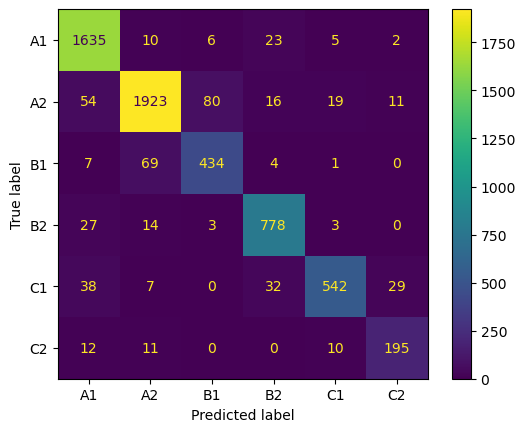

In [65]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = test['predictions']

y_true = test['level']

def map_func(x):
    return label_to_id_mapping.get(x, -1)

y_true_mapped = np.vectorize(map_func)(y_true)
y_pred_mapped = np.vectorize(map_func)(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
print(f'Accuracy: {accuracy:.3f}')

# Generate accuracy report
unique_labels = set(y_true_mapped)  # Get unique labels

for label in unique_labels:
    label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
    label_y_true = [y_true_mapped[i] for i in label_indices]
    label_y_pred = [y_pred_mapped[i] for i in label_indices]
    label_accuracy = accuracy_score(label_y_true, label_y_pred)
    print(f'Accuracy for label {cefr_levels[label]}: {label_accuracy:.3f}')

class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))))
class_report_dict = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))), output_dict=True)
print('\nClassification Report:')
print(class_report)
table_data = []

for key, value in class_report_dict.items():
    if isinstance(value, dict):
        table_data.append([
            key,
            value.get("precision", 0),
            value.get("recall", 0),
            value.get("f1-score", 0),
            value.get("support", 0)
        ])
    else:
        # For accuracy, add precision and recall as 0
        table_data.append([
            key,
            0,
            0,
            value,
            class_report_dict["weighted avg"]["support"]
        ])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(cefr_levels))))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=cefr_levels)
disp.plot()


print('\nConfusion Matrix:')
print(conf_matrix)

wandb.log({
    "Class Proportions": wandb.sklearn.plot_class_proportions(train['level'], test['level'], cefr_levels),
    "Confusion Matrix": plt,
    "Classification Report": wandb.Table(data=table_data, columns=['Class/Metric', 'Precision', 'Recall', 'F1-score', 'Support'])
})

In [66]:
wandb.finish()